In [65]:
import yaml
import torch
import os
os.chdir('C:/Users/clack/Projects/nwm')

from experiment.vae import make_vae
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from diffusion import create_diffusion
from isolated_nwm_infer import model_forward_wrapper
from misc import transform, unnormalize
from models import CDiT_models
from datasets import Nav2dTopoDataset

EXP_NAME = 'nwm_cdit_s'
MODEL_PATH = 'D:/nwm-out/nwm-cdit-s-topo2/checkpoints/495.pth.tar'

with open("config/data_config.yaml", "r") as f:
    default_config = yaml.safe_load(f)
config = default_config

with open(f'config/{EXP_NAME}.yaml', "r") as f:
    user_config = yaml.safe_load(f)
config.update(user_config)
latent_size = config['image_size'] // 8
print(latent_size)
print("loading model")
import pathlib
pathlib.PosixPath = pathlib.WindowsPath
model = CDiT_models['CDiT-S/2'](input_size=latent_size, context_size=config['context_size'])
ckp = torch.load(MODEL_PATH, map_location='cpu', weights_only=False) 

print(model.load_state_dict(ckp["ema"], strict=True))
model.eval()
device = 'cuda'
model.to(device)
model = torch.compile(model)

diffusion = create_diffusion(str(250))
vae = make_vae().to(device)
vae.load_state_dict(torch.load('checkpoints/vae/topo/check1049.pt'))


# train_dataset = Nav2dTopoDataset(
#     size=1000,
#     resolution=config['image_size'],
#     context_size=config['context_size'],
#     goal_count=4,
#     max_step_distance=8,
#     max_angular_drift=torch.pi,
#     transform=transform
# )

16
loading model
<All keys matched successfully>


<All keys matched successfully>

In [66]:
import numpy as np
from experiment.nav2d import Topo
import torch._dynamo
torch._dynamo.config.disable = True

# vae.encode(x_cond_pixels[0])
@torch.no_grad()
def model_forward_wrapper(model, diffusion, current_latent, curr_delta, latent_size, device, progress=False):
  y = curr_delta.to(device)
  with torch.amp.autocast('cuda', enabled=True, dtype=torch.bfloat16):
    z = torch.randn(1, 4, latent_size, latent_size, device=device)
    y = y.flatten(0, 1)
    model_kwargs = dict(y=y, x_cond=current_latent.unsqueeze(0).unsqueeze(0), rel_t=torch.ones(1, device=device))      
    latents = diffusion.p_sample_loop(
      model.forward, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=progress, device=device
    )
  return latents

@torch.no_grad()
def encode_image(image: np.ndarray):
  x_cond_pixels = transform(torch.from_numpy(image.copy()).permute(2, 0, 1)).unsqueeze(0).to(device, dtype=torch.float32)
  return vae.encode(x_cond_pixels)[0]
  
@torch.no_grad()
def cdit_forward(current_latent: torch.Tensor, action: np.ndarray, progress: bool = False):
  y = torch.tensor([[[*action, 0.0]]], device=device)
  with torch.amp.autocast('cuda', enabled=True, dtype=torch.bfloat16):
    z = torch.randn(1, 4, latent_size, latent_size, device=device)
    y = y.flatten(0, 1)
    model_kwargs = dict(y=y, x_cond=current_latent.unsqueeze(0).unsqueeze(0), rel_t=torch.ones(1, device=device))      
    latents = diffusion.p_sample_loop(
      model.forward, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=progress, device=device
    )
  decoded_image = unnormalize(vae.decode(latents)[0]).detach().cpu().permute(1, 2, 0).to(dtype=torch.float32).numpy().astype(np.float32)
  return latents[0], decoded_image

  0%|          | 0/250 [00:00<?, ?it/s]

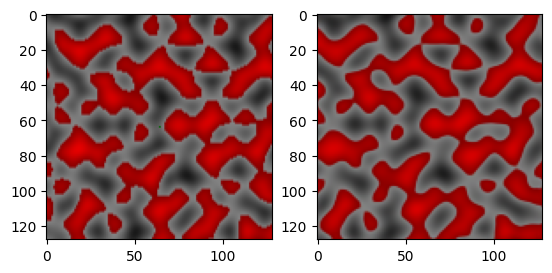

In [67]:
import matplotlib.pyplot as plt

state = Topo.random()
image = state.render(128)
latent, next_predicted_image = cdit_forward(encode_image(image), np.array([5, 0]), progress=True)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[1].imshow(next_predicted_image)

In [68]:
import cv2
import numpy as np
from experiment.nav2d import Topo

state = Topo.random()
CAMERA_RESOLUTION = 128
UPSCALE_RESOLUTION = 512

def upscale(image: np.ndarray):
  return cv2.resize(
    cv2.cvtColor(
      image,
      cv2.COLOR_RGB2BGR
    ),
    (UPSCALE_RESOLUTION, UPSCALE_RESOLUTION),
    interpolation=cv2.INTER_NEAREST
  )

def on_click(event, x, y, flags, param):
  global latent
  if event != cv2.EVENT_LBUTTONDOWN:
    return
  click_position = np.array([x, y]) / UPSCALE_RESOLUTION
  displacement = (click_position - 0.5) * CAMERA_RESOLUTION
  state.act(displacement)

  real_image = state.render(CAMERA_RESOLUTION).astype(np.float32)
  latent, predicted_image = cdit_forward(latent, displacement)
  side_by_side = np.concatenate((upscale(real_image), upscale(predicted_image)), axis=1)
  cv2.imshow('worldstate', side_by_side)

initial_image = state.render(CAMERA_RESOLUTION).astype(np.float32)
latent = encode_image(initial_image)

side_by_side = np.concatenate((upscale(initial_image), upscale(initial_image)), axis=1)
cv2.imshow('worldstate', side_by_side)
cv2.setMouseCallback('worldstate', on_click)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [52]:
import cv2
from IPython.display import Video
from tqdm import tqdm

class WindingWalkPolicy:
  def __init__(self, step_size: float = 2, max_wind_per_step: float = 1.0) -> None:
    self.step_size = step_size
    self.max_angular_deviation = max_wind_per_step
    self.angle = np.random.rand() * 2 * np.pi

  def __call__(self, _) -> np.ndarray:
    self.angle += 2 * (np.random.rand() - 0.5) * self.max_angular_deviation
    return self.step_size * np.array([np.cos(self.angle), np.sin(self.angle)])

out_path = 'out.mp4'
state = Topo.random()
policy = WindingWalkPolicy()

# actual_images = [state.render(128).astype(np.float32)]
# predicted_images = [actual_images[0]]
# latent = encode_image(actual_images[0])
# for frame in tqdm(range(20), desc='CDiT forward passes'):
#   action = policy(state)
#   state.act(action)

#   latent, decoded_image = cdit_forward(latent, action)
#   actual_images.append(state.render(128).astype(np.float32))
#   predicted_images.append(decoded_image.astype(np.float32))

# render_images =  [
#   np.concatenate((upscale(actual), upscale(predicted)), axis=1)
#   for actual, predicted in zip(actual_images, predicted_images)
# ]
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), 1, (render_images[0].shape[1], render_images[0].shape[0]))
for image in render_images:
  out.write((image * 255).astype(np.uint8))
out.release()

Video(out_path)

In [2]:
import os
os.chdir('C:/Users/clack/Projects/nwm')
import heapq
import numpy as np
from experiment.nav2d import Topo

def distance_map(
  state: Topo, start: np.ndarray, max_distance: float, forbidden_margin: int = 0
) -> np.ndarray:
  start_block = start.round().astype(np.uint32)
  
  distance = np.full((state.terrain_size, state.terrain_size), np.inf, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  visited = np.zeros((state.terrain_size, state.terrain_size), dtype=bool)
  heads = [(0.0, tuple(start_block))]
  
  while heads:
    distance_from_start, head_tuple = heapq.heappop(heads)
    head = np.array(head_tuple, dtype=np.uint32)
    
    if visited[head[1], head[0]]:
      continue
    visited[head[1], head[0]] = True

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < forbidden_margin).any(-1) | (neighbors >= state.terrain_size - forbidden_margin).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])
      | (estimated_neighbor_distances > max_distance)
    )
    neighbors = neighbors[~dead_end]
    estimated_neighbor_distances = estimated_neighbor_distances[~dead_end]
    
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances
    for neighbor, dist in zip(neighbors, estimated_neighbor_distances):
      heapq.heappush(heads, (dist, tuple(neighbor)))

  return distance

In [62]:
from typing import Callable, Generic, List, Sequence, Tuple, TypeVar

S = TypeVar('S')
A = TypeVar('A')
class PlanningGraph(Generic[S, A]):
  def __init__(
    self,
    world_model: Callable[[Sequence[S], Sequence[A]], Sequence[S]],
    distance_function: Callable[[Sequence[S], Sequence[S]], Sequence[float]],
    sample_actions: Callable[[Sequence[S]], Sequence[Sequence[A]]]
  ) -> None:
    self.world_model = world_model
    self.distance_function = distance_function
    self.sample_actions = sample_actions

    self.priorities: List[float] = []
    self.nodes: List[S] = []
    self.explored_edges: List[List[Tuple[int, A]]] = []
    self.unexplored_edges: List[List[A]] = []
    self.distances_to_goal: List[float] = []

    # 1. choose node with closest distance to goal
    # 2. choose node least saturated with actions

    # we could score actions based on:
    # 1. how close the root node is to the goal
    # X 2. how close neighbors to the root node are to the goal X (distance function should encapsulate)
    # 2. how unexplored the actions of a node are

  def plan_trajectory(self, starting_state: S, goal_state: S) -> List[A] | None:
    ambivalence = 0.2
    success_distance_threshold = 3.0

    self.distances_to_goal = [max(1, self.distance_function([starting_state], [goal_state])[0])]
    self.nodes = [starting_state]
    self.source_edges = [(-1, None)]
    self.unexplored_edges = [list(self.sample_actions([starting_state])[0])]

    if self.distances_to_goal[0] <= success_distance_threshold:
      return []

    explorations_allowed = 30
    while explorations_allowed:
      explorations_allowed -= 1
      unexplored_edges = sum([[
        (state_index, action_index) for action_index in range(len(actions))
      ] for state_index, actions in enumerate(self.unexplored_edges)], [])
      if not unexplored_edges:
        break
      relative_distances_to_goal = np.array(self.distances_to_goal) - min(self.distances_to_goal)
      # print(relative_distances_to_goal)
      if relative_distances_to_goal.max() > 0:
        relative_distances_to_goal = relative_distances_to_goal / relative_distances_to_goal.max()

        distance_scores = np.array([relative_distances_to_goal[state_index] for state_index, _ in unexplored_edges])
        distance_scores = distance_scores.max() - distance_scores
        distance_scores = distance_scores / distance_scores.sum()
      else:
        distance_scores = np.ones(len(unexplored_edges)) / len(unexplored_edges)
      # print(distance_scores)
      # print(distance_scores)
      edge_scores = distance_scores * (1 - ambivalence) + np.full_like(distance_scores, ambivalence / len(distance_scores))

      # print(edge_scores)
      state_index, action_index = unexplored_edges[
        np.random.choice(np.arange(len(unexplored_edges), dtype=np.int32), p=edge_scores)
      ]
      action = self.unexplored_edges[state_index].pop(action_index)
      # [].pop()
      state = self.nodes[state_index]
      new_state = self.world_model([state], [action])[0]
      goal_distance = self.distance_function([new_state], [goal_state])[0]

      # distances_to_others = self.distance_function([new_state] * len(self.nodes), self.nodes)
      # if min(distances_to_others) > 1:
      self.unexplored_edges.append(list(self.sample_actions([new_state])[0]))

      self.nodes.append(new_state)
      self.source_edges.append((state_index, action))
      self.distances_to_goal.append(max(1, goal_distance))

      if goal_distance <= success_distance_threshold:
        trajectory = []
        current_state_index = len(self.nodes) - 1
        while current_state_index != 0:
          current_state_index, action = self.source_edges[current_state_index]
          trajectory.append(action)
        return list(reversed(trajectory))
    return None

def world_model(states: Sequence[Topo], actions: Sequence[np.ndarray]) -> List[Topo]:
  next_states = []
  for state, action in zip(states, actions):
    next_state = state.copy()
    next_state.act(action)
    next_states.append(next_state)
  return next_states

def distance_function(states1: Sequence[Topo], states2: Sequence[Topo]) -> List[float]:
  distances = []
  for state1, state2, in zip(states1, states2):
    target_position = state2.position.round().astype(np.long)
    distance = distance_map(state1, start=state1.position, max_distance=128)[target_position[1], target_position[0]]
    distances.append(distance)
  return distances




graph = PlanningGraph(
  world_model=world_model,
  distance_function=distance_function,
  sample_actions=lambda states: (
    len(states) * [
      [4 * np.array([np.cos(angle), np.sin(angle)]) for angle in np.arange(0, 2 * np.pi, np.pi / 2)]
    ])
)




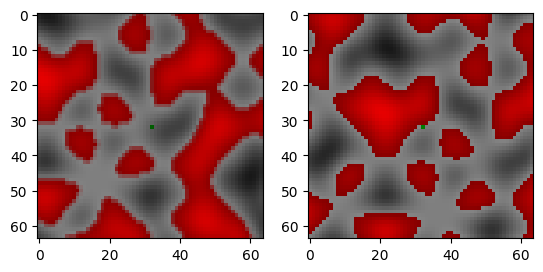

In [50]:
start_state = Topo.random()
target_position = (state.position + (np.random.rand(2) * 2 - 1) * 20).round().astype(np.int32)
while state.terrain[target_position[1], target_position[0]] >= state.wall_height:
  target_position = (state.position + (np.random.rand(2) * 2 - 1) * 20).round().astype(np.int32)

start_state_image = start_state.render(64)

goal_state = start_state.copy()
goal_state.position = target_position
goal_state_image = goal_state.render(64)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)
axes[0].imshow(start_state_image)
axes[1].imshow(goal_state_image)

None


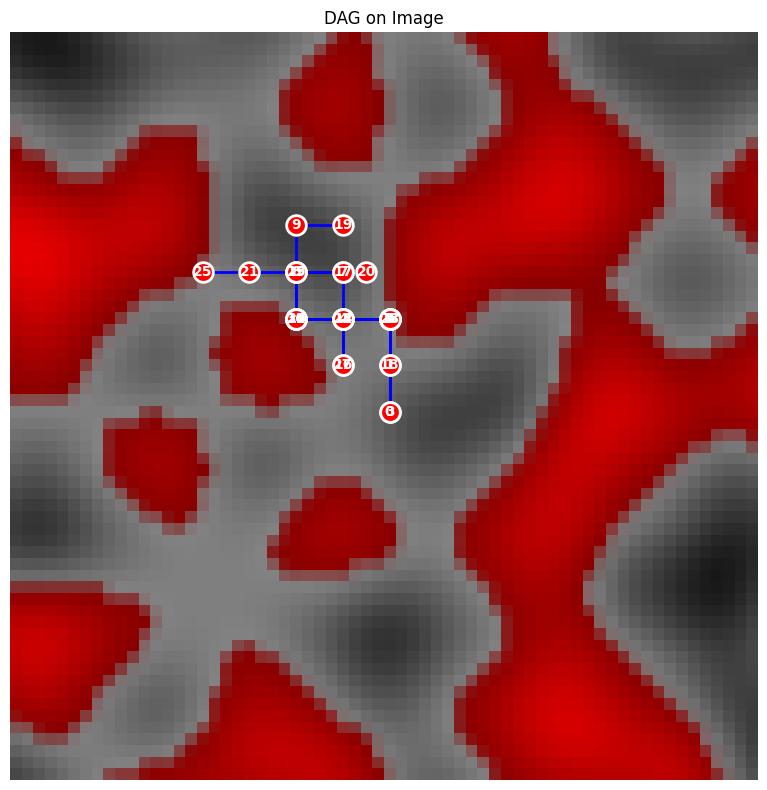

In [ ]:
trajectory = graph.plan_trajectory(start_state, goal_state)
print(trajectory)
plt.figure(figsize=(10, 8))
plt.imshow(start_state_image)

nodes = [state.position - start_state.position + 32 for state in graph.nodes]
parent = [node_index for node_index, _ in graph.source_edges]

# nodes = [np.array([32, 14]), np.array([3, 7])]
# parent = [-1, 0]

# Draw edges first (so they appear behind nodes)
for i, p in enumerate(parent):
    if p != -1:  # Skip root node
        # Draw line from parent to current node
        x = [nodes[p][0], nodes[i][0]]
        y = [nodes[p][1], nodes[i][1]]
        plt.plot(x, y, 'b-', linewidth=2, zorder=1)

# Draw nodes on top
for i, node in enumerate(nodes):
    # Draw node as a circle
    plt.scatter(node[0], node[1], s=200, c='red',
                edgecolors='white', linewidths=2, zorder=2)
    # Optionally add node labels
    plt.text(node[0], node[1], str(i), fontsize=10,
             fontweight='bold', ha='center', va='center',
             color='white', zorder=3)

plt.title("DAG on Image")
plt.axis('off')  # Optional: hide axes
plt.tight_layout()
plt.show()

In [32]:
sum([0.72649574 ,0.72649574, 0.72649574, 0.72649574, 0.72649574, 0.72649574,
 0.72649574, 0.72649574 ,0.72649574 ,0.8153846  ,0.8153846 , 0.8153846,
 0.8153846 ])

9.800000059999999